# Импортирование необходимых библиотек

In [52]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math, re
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

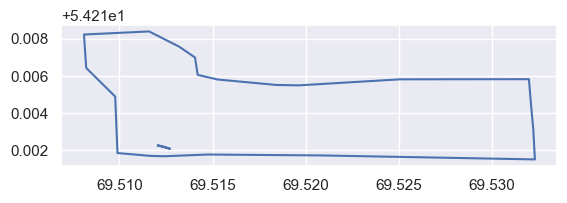

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Составление маски пастбища

In [8]:
aoi_height, aoi_width = pasture_size[-1], pasture_size[0]

In [9]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

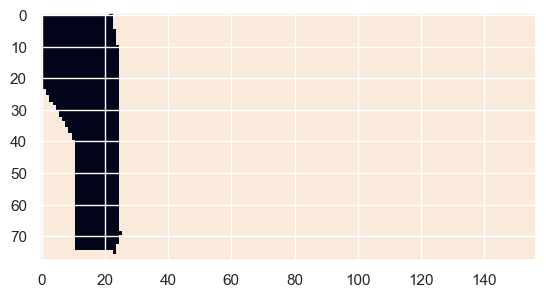

In [10]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

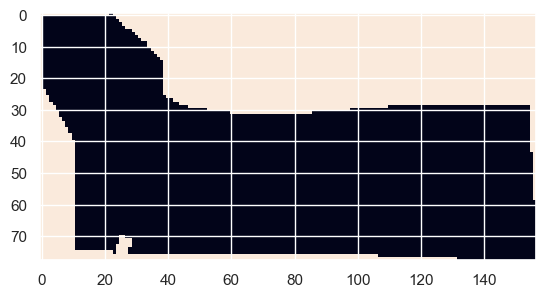

In [11]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [12]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

bands_dict = dict()

# Анализ погодных параметров и каналов

In [13]:
training_df = pd.read_csv("train_data.csv")
training_df

,time,greenmass,zagon
0,2022-06-09,0.80,2
1,2022-06-09,1.00,3
2,2022-06-09,1.20,5
3,2022-06-09,1.10,6
4,2022-07-14,1.40,2
5,2022-07-14,1.20,3
6,2022-08-03,2.20,4
7,2022-08-03,1.90,5
8,2022-08-03,0.90,6
9,2022-08-03,0.60,7


# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [14]:
def get_date_data(date_chosen, zagon, greenmass, collection, by_pasture=True):
    global bands_dict
    
    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)


    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B01"]],zagon)))

        BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B02"]],zagon)))
        GREEN = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B03"]],zagon)))
        RED = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B04"]],zagon)))

        RED_EDGE1 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B05"]],zagon)))
        RED_EDGE2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B06"]],zagon)))
        RED_EDGE3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B07"]],zagon)))

        NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B08"]],zagon)))
        N_NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B8A"]],zagon)))
        WV = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B09"]],zagon)))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B10"]],zagon)))
        SWIR2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B11"]],zagon)))
        SWIR3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B12"]],zagon)))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])),zagon)

        BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])),zagon)
        GREEN = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])),zagon)
        RED = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])),zagon)

        RED_EDGE1 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])),zagon)
        RED_EDGE2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])),zagon)
        RED_EDGE3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])),zagon)

        NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])),zagon)
        N_NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])),zagon)
        WV = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])),zagon)
        if "B10" in bands_dict:
            SWIR_C = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])),zagon)
        SWIR2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])),zagon)
        SWIR3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])),zagon)

    print(f"Успешно получены каналы для даты: {date_chosen} и загона №{zagon}")
    if "B10" in bands_dict:
        return ["time", "zagon", "greenmass"] + list(bands_dict.keys()) + list(aux_data_dict.keys()), [date_chosen, zagon, greenmass, ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SZA, SAA, VZM, VAM]
    else:
        return ["time", "zagon", "greenmass"] + list(bands_dict.keys()) + list(aux_data_dict.keys()), [date_chosen, zagon, greenmass, ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR2, SWIR3, SZA, SAA, VZM, VAM]

# Получение данных ДЗЗ по доступным датам

In [15]:
from itertools import permutations, combinations, product
from math import factorial

In [16]:
# test_index = eval(formula_text)

# test_thresh = test_index.min() 
# #     test_thresh = (test_index.max() + test_index.min())/2
# # test_thresh = 0

# test_filter = test_index >= test_thresh; test_mask = ~test_filter
# test_meet = ma.masked_array(test_index, mask=test_mask)

# # lower_bound = -1;  upper_bound = 1
# lower_bound = test_meet.min(); upper_bound = test_meet.max()    
# mask = (test_meet < lower_bound) | (test_meet > upper_bound)

# test_meet = ma.masked_array(test_meet, mask=mask)

# ep.plot_bands(test_meet, title=f"Канал для даты: {date_chosen} и загона №{zagon}", cmap="viridis")

# #     test_meet = test_meet.mean()
# #     test_meet = ma.median(test_meet)
# test_meet = test_meet.sum()

In [17]:
sample_form = []
for index in training_df.index:
    data_lables, data_list = get_date_data(training_df.loc[index, 'time'], training_df.loc[index, 'zagon'], training_df.loc[index, 'greenmass'], "L2A", by_pasture=False)
    sample_form.append(data_list)    

Успешно получены каналы для даты: 2022-06-09 и загона №2
Успешно получены каналы для даты: 2022-06-09 и загона №3
Успешно получены каналы для даты: 2022-06-09 и загона №5
Успешно получены каналы для даты: 2022-06-09 и загона №6
Успешно получены каналы для даты: 2022-07-14 и загона №2
Успешно получены каналы для даты: 2022-07-14 и загона №3
Успешно получены каналы для даты: 2022-08-03 и загона №4
Успешно получены каналы для даты: 2022-08-03 и загона №5
Успешно получены каналы для даты: 2022-08-03 и загона №6
Успешно получены каналы для даты: 2022-08-03 и загона №7
Успешно получены каналы для даты: 2023-05-15 и загона №2
Успешно получены каналы для даты: 2023-05-22 и загона №3
Успешно получены каналы для даты: 2023-06-09 и загона №6
Успешно получены каналы для даты: 2023-06-14 и загона №7
Успешно получены каналы для даты: 2023-07-04 и загона №3
Успешно получены каналы для даты: 2023-07-09 и загона №4
Успешно получены каналы для даты: 2023-07-14 и загона №5


In [18]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)
indices_df

,time,zagon,greenmass,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,sunZenithAngles,sunAzimuthAngles,viewZenithMean,viewAzimuthMean
0,2022-06-09,2,0.80,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
1,2022-06-09,3,1.00,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
2,2022-06-09,5,1.20,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
3,2022-06-09,6,1.10,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
4,2022-07-14,2,1.40,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",33.603001,161.464020,5.193906,272.806152
5,2022-07-14,3,1.20,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--

In [19]:
combination_results = dict()
for bands_combination in permutations(list(bands_dict.keys()), 4):
    calculated_GM = []
    for sample in indices_df.index:
        term1 = indices_df.iloc[sample][f"{bands_combination[0]}"]
        term2 = indices_df.iloc[sample][f"{bands_combination[1]}"]
        term3 = indices_df.iloc[sample][f"{bands_combination[2]}"]
        term4 = indices_df.iloc[sample][f"{bands_combination[3]}"]

        formula = (term1+term2)/(term3+term4)
        final_value = ma.median(formula)
        calculated_GM.append(final_value)

    combination_results[bands_combination] = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]

print("Всего комбинации: ", len(combination_results))    

C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Всего комбинации:  11880


In [20]:
dict(sorted(combination_results.items(), key=lambda item: item[1]))

{('B04', 'B12', 'B02', 'B08'): -0.8933478820434873,
 ('B04', 'B12', 'B08', 'B02'): -0.8933478820434873,
 ('B04', 'B12', 'B02', 'B07'): -0.882984122533987,
 ('B04', 'B12', 'B07', 'B02'): -0.882984122533987,
 ('B04', 'B12', 'B02', 'B09'): -0.8601191408858877,
 ('B04', 'B12', 'B09', 'B02'): -0.8601191408858877,
 ('B04', 'B12', 'B02', 'B8A'): -0.8501182650856728,
 ('B04', 'B12', 'B8A', 'B02'): -0.8501182650856728,
 ('B04', 'B12', 'B02', 'B11'): -0.8191698494184356,
 ('B04', 'B12', 'B11', 'B02'): -0.8191698494184356,
 ('B06', 'B12', 'B07', 'B08'): -0.7981817084353108,
 ('B06', 'B12', 'B08', 'B07'): -0.7981817084353108,
 ('B07', 'B12', 'B08', 'B09'): -0.7832673645798337,
 ('B07', 'B12', 'B09', 'B08'): -0.7832673645798337,
 ('B8A', 'B12', 'B08', 'B11'): -0.7749263215663198,
 ('B8A', 'B12', 'B11', 'B08'): -0.7749263215663198,
 ('B8A', 'B12', 'B08', 'B09'): -0.7630250569042727,
 ('B8A', 'B12', 'B09', 'B08'): -0.7630250569042727,
 ('B07', 'B12', 'B08', 'B8A'): -0.7626180725566682,
 ('B07', 'B12'

In [21]:
dict(sorted(combination_results.items(), key=lambda item: item[1], reverse=True))

{('B02', 'B08', 'B04', 'B12'): 0.8950210627753503,
 ('B02', 'B08', 'B12', 'B04'): 0.8950210627753503,
 ('B08', 'B02', 'B04', 'B12'): 0.8950210627753503,
 ('B08', 'B02', 'B12', 'B04'): 0.8950210627753503,
 ('B02', 'B07', 'B04', 'B12'): 0.8865002116927954,
 ('B02', 'B07', 'B12', 'B04'): 0.8865002116927954,
 ('B07', 'B02', 'B04', 'B12'): 0.8865002116927954,
 ('B07', 'B02', 'B12', 'B04'): 0.8865002116927954,
 ('B02', 'B09', 'B04', 'B12'): 0.8626886967713279,
 ('B02', 'B09', 'B12', 'B04'): 0.8626886967713279,
 ('B02', 'B8A', 'B04', 'B12'): 0.8547510982699348,
 ('B02', 'B8A', 'B12', 'B04'): 0.8547510982699348,
 ('B8A', 'B02', 'B04', 'B12'): 0.8547510982699348,
 ('B02', 'B11', 'B04', 'B12'): 0.8284141648957228,
 ('B02', 'B11', 'B12', 'B04'): 0.8284141648957228,
 ('B07', 'B08', 'B06', 'B12'): 0.8046645004305556,
 ('B07', 'B08', 'B12', 'B06'): 0.8046645004305556,
 ('B05', 'B08', 'B04', 'B12'): 0.7786320306966187,
 ('B05', 'B08', 'B12', 'B04'): 0.7786320306966187,
 ('B08', 'B05', 'B04', 'B12'): 

# Анализ перед обучением

In [22]:
# # Calculate the correlation matrix
# correlation_matrix = input_df.corr()

# # Create a heatmap using seaborn
# plt.figure(figsize=(18, 16))
# sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f", linewidths=.5)

# plt.axvline(x=18, color='black', linewidth=2)
# plt.axvline(x=19, color='black', linewidth=2)

# plt.axhline(y=13, color='black', linewidth=2)
# plt.axhline(y=14, color='black', linewidth=2)

# plt.title("Correlation Matrix Plot")
# plt.show()

In [23]:
# plt.plot(range(len(input_df.index)), input_df["index"]/100, label='Прогноз со спутника')
# plt.plot(range(len(input_df.index)), input_df["greenmass"], label='Наземные данные')
# # plt.plot(range(len(input_df.index)), input_df["sunZenithAngles"], label='SZA')

# plt.title('Урожайность реальная vs Урожайность прогноз')
# plt.legend()
# plt.show()

# Генетический алгоритм

In [24]:
# def masked_matrix_median(masked_matrix):
#     return ma.median(masked_matrix)

# bands_matrices = indices_df.iloc[:,3:15]
# green_mass = indices_df.iloc[:,2:3]

# bands_matrices_median = bands_matrices.applymap(masked_matrix_median)

In [25]:
from itertools import permutations
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import numpy.ma as ma

# Set up DEAP framework for Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("indices", np.random.permutation, len(bands_dict))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    bands_combination = [list(bands_dict.keys())[i] for i in individual[:4]]
    
    calculated_GM = []
    for sample in indices_df.index:
        terms = [indices_df.iloc[sample][f"{band}"] for band in bands_combination]
        formula = (terms[0] + terms[1]) / (terms[2] + terms[3])
        final_value = ma.median(formula)
        calculated_GM.append(final_value)
    
    correlation = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]
    return correlation,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    # Assuming you have initialized your indices_df dataframe

    # Set random seed for reproducibility
#     np.random.seed(42)

    # Create an initial population
    population_size = 10
    population = toolbox.population(n=population_size)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Crossover and mutation probabilities
    cxpb, mutpb = 0.7, 0.2

    # Number of generations
    ngen = 5

    # Statistics to collect during the optimization
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)

    # Run the Genetic Algorithm
    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2*population_size,
                              cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=None, verbose=True)

    # Get the best individual and its fitness value
    best_individual = tools.selBest(population, k=1)[0]
    best_combination = [list(bands_dict.keys())[int(i)] for i in best_individual[:4]]
    best_fitness = best_individual.fitness.values[0]

    print("Лучшая комбинация каналов:", best_combination)
    print("Лучшая корреляция:", best_fitness)

gen	nevals	max     
0  	0     	0.716104
1  	178   	0.895021
2  	184   	0.895021
3  	180   	0.895021
4  	186   	nan     
5  	184   	0.895021
6  	173   	0.895021
7  	183   	0.895021
8  	183   	0.895021
9  	179   	0.895021
10 	172   	0.895021
Лучшая комбинация каналов: ['B02', 'B08', 'B04', 'B12']
Лучшая корреляция: 0.8950210627753503


In [26]:
# combination_results = dict()
# for bands_combination in permutations(list(bands_dict.keys()), 4):
#     calculated_GM = []
#     for sample in indices_df.index:
#         term1 = indices_df.iloc[sample][f"{bands_combination[0]}"]
#         term2 = indices_df.iloc[sample][f"{bands_combination[1]}"]
#         term3 = indices_df.iloc[sample][f"{bands_combination[2]}"]
#         term4 = indices_df.iloc[sample][f"{bands_combination[3]}"]

#         formula = (term1+term2)/(term3+term4)
#         final_value = ma.median(formula)
#         calculated_GM.append(final_value)

#     combination_results[bands_combination] = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]

# Clarification of the code above:    
# 1) "indices_df" dataframe has 17 rows and 13 columns, namely: "greenmass" and 12 bands ("B01", "B02" ... and so on)
# 2) each band is a masked matrix of size (175, 78)
# 3) This code searches for the best possible combination of 4 bands out of 12 bands.
# 4) Correlation with "greenmass" column is assessed
# 5) bands_dict dictionary's keys contain bands' names as strings ("B01", "B02" ... and so on)

# Actually, it does fine. I was able to find a set of bands with a 90% correlation. So, my question is what kind of Machine Learning or Optimization Algorithm can do the same?

In [27]:
# band = "B12"
# cmap = "viridis"
# for i in indices_df.index:
#     ep.plot_bands(indices_df.iloc[i][band], title=f"{indices_df.iloc[i]['time']} || {indices_df.iloc[i]['zagon']}", cmap=cmap)

In [79]:
indices = [
    "(NIR - RED) / (NIR + RED)",
    "2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)",
    "(NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5)",
    "((NIR - RED) / (NIR + RED))**(0.5)",
    "(NIR - GREEN) / (NIR + GREEN)",
    "(NIR - SWIR3) / (NIR + SWIR3)",
    "(NIR / RED) - 1",
    "(NIR / RED_EDGE1) - 1",
    "(RED_EDGE1 - RED) / (RED_EDGE1 + RED)",
    "(NIR - RED_EDGE1) / (NIR + RED_EDGE1)",
    "(NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)",
    "(GREEN - RED) / (GREEN + RED - BLUE)",
    "(BLUE+NIR)/(RED+SWIR3)",
    "ULTRA_BLUE",
    "BLUE",
    "GREEN",
    "RED",
    "RED_EDGE1",
    "RED_EDGE2",
    "RED_EDGE3",
    "NIR",
    "N_NIR",
    "WV",
    "SWIR2",
    "SWIR3",
]

methods = ["mean", "median", "harmonic", "geometric", "max", "min", "sum"]

def substitute_values(input_string):
    replacements = {
        'ULTRA_BLUE': 'indices_df.iloc[sample]["B01"]',
        'BLUE': 'indices_df.iloc[sample]["B02"]',
        'GREEN': 'indices_df.iloc[sample]["B03"]',
        'RED': 'indices_df.iloc[sample]["B04"]',
        'RED_EDGE1': 'indices_df.iloc[sample]["B05"]',
        'RED_EDGE2': 'indices_df.iloc[sample]["B06"]',
        'RED_EDGE3': 'indices_df.iloc[sample]["B07"]',
        'NIR': 'indices_df.iloc[sample]["B08"]',
        'N_NIR': 'indices_df.iloc[sample]["B8A"]',
        'WV': 'indices_df.iloc[sample]["B09"]',
        'SWIR2': 'indices_df.iloc[sample]["B11"]',
        'SWIR3': 'indices_df.iloc[sample]["B12"]',
    }

    # Use regular expressions to replace whole words only
    for key, value in replacements.items():
        pattern = r'\b{}\b'.format(re.escape(key))
        input_string = re.sub(pattern, value, input_string)
    
    return input_string

In [80]:
outer_layer = dict()
for index in indices:
    outer_layer[index] = dict()
    for method in methods:
        outer_layer[index][method] = dict()
        values = []
        for sample in indices_df.index:
            result = substitute_values(index).replace("sample", str(sample))
            if method == "mean":
                value = eval(result).mean()
            elif method == "median":
                value = ma.median(eval(result))
            elif method == "harmonic":
                try:
                    value = hmean(eval(result).reshape(eval(result).shape[1] * eval(result).shape[0]))
                except ValueError:
                    value = np.nan
            elif method == "geometric":
                try:
                    value = gmean(eval(result).reshape(eval(result).shape[1] * eval(result).shape[0]))
                except ValueError:
                    value = np.nan
            elif method == "max":
                value = eval(result).max()
            elif method == "min":
                value = eval(result).min()
            else:
                value = eval(result).sum()
            
            values.append(value)
        outer_layer[index][method] = np.corrcoef(values, list(indices_df["greenmass"]))[0, 1]
            

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:307: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:307: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [81]:
pd.DataFrame(outer_layer).transpose()

,mean,median,harmonic,geometric,max,min,sum
(NIR - RED) / (NIR + RED),0.548396,0.567964,0.542080,0.545483,0.572421,0.322224,0.385073
2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1),0.635350,0.658631,0.625618,0.630823,0.530787,0.371067,0.461844
(NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5),0.548472,0.568371,0.543989,0.546450,0.561499,0.327790,0.368194
((NIR - RED) / (NIR + RED))**(0.5),0.522357,0.541445,0.519150,0.520800,0.564981,0.323398,0.223317
(NIR - GREEN) / (NIR + GREEN),0.398143,0.415020,0.396761,0.397479,0.322103,0.361863,0.182599
(NIR - SWIR3) / (NIR + SWIR3),0.724831,0.771272,NaN,NaN,0.575750,0.275820,0.730830
(NIR / RED) - 1,0.653675,0.653943,0.617510,0.636979,0.625230,0.291525,0.589019
(NIR / RED_EDGE1) - 1,0.455255,0.504264,0.459665,0.452179,0.229703,0.328749,0.331842
(RED_EDGE1 - RED) / (RED_EDGE1 + RED),0.623832,0.634587,NaN,NaN,0.566445,0.376218,0.538184
(NIR - RED_EDGE1) / (NIR + RED_EDGE1),0.440125,0.467606,0.411350,0.408245,0.305010,0.346468,0.292550


In [82]:
pd.DataFrame(outer_layer).transpose().to_excel("ComparisoinTable.xlsx")